  class_name       tempo  chroma_stft      rmse  spectral_centroid  \
0      blues  103.359375     0.380260  0.248262        2116.942959   
1      blues   95.703125     0.306451  0.113475        1156.070496   
2      blues  151.999081     0.253487  0.151571        1331.073970   
3      blues  184.570312     0.269320  0.119072        1361.045467   
4      blues  161.499023     0.391059  0.137728        1811.076084   

   spectral_bandwidth      rolloff  zero_crossing_rate       mfcc1  \
0         1956.611056  4196.107960            0.127272  -26.929785   
1         1497.668176  2170.053545            0.058613 -233.860772   
2         1973.643437  2900.174130            0.042967 -221.802549   
3         1567.804596  2739.625101            0.069124 -207.208080   
4         2052.332563  3927.809582            0.075480 -145.434568   

        mfcc2  ...     mfcc12     mfcc13    mfcc14    mfcc15    mfcc16  \
0  107.334008  ...  14.336612 -13.821769  7.562789 -6.181372  0.330165   
1  136.170

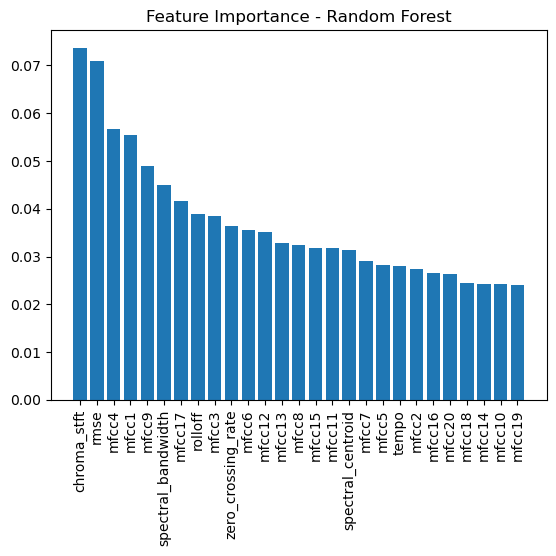

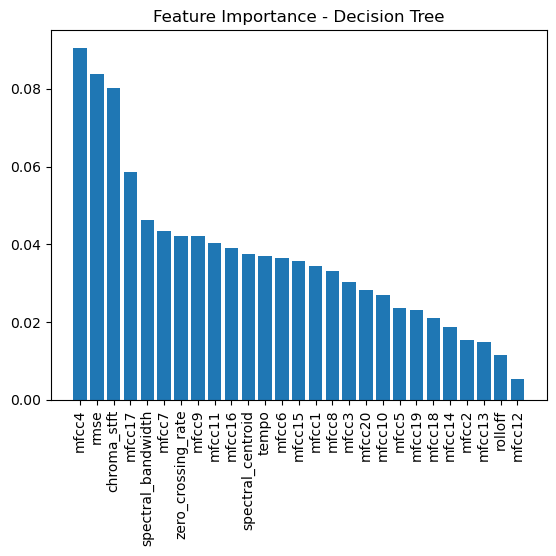

KNN Test Score: 0.652


C:\Users\anjal\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Predicted genre using KNN: metal
SVM Test Score: 0.756
Predicted genre using SVM: blues


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import librosa
import pickle


# Load the dataset
df = pd.read_csv('C:/Users/anjal/Downloads/data (1).csv')

# Drop the 'beats' column as it's not needed
df = df.drop(['beats'], axis=1)

# Display the first few rows of the dataframe
print(df.head())

# Preprocessing
# Convert 'class_name' to category type and create 'class_label' as the codes of the categories
df['class_name'] = df['class_name'].astype('category')
df['class_label'] = df['class_name'].cat.codes

# Create a lookup dictionary for genre names
lookup_genre_name = dict(zip(df.class_label.unique(), df.class_name.unique()))

# Display unique class names to ensure correct processing
print(df['class_name'].unique())

# List of feature columns
cols = list(df.columns)
cols.remove('label')
cols.remove('class_label')
cols.remove('class_name')

# Data Splitting for Training and Testing
X = df.iloc[:, 1:28]
y = df['class_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

# Min-Max Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature importance using Random Forest
clf_rf = RandomForestClassifier(random_state=0, n_jobs=-1).fit(X_train_scaled, y_train)
importances_rf = clf_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
names_rf = [X.columns.values[i] for i in indices_rf]
plt.figure()
plt.title("Feature Importance - Random Forest")
plt.bar(range(X.shape[1]), importances_rf[indices_rf])
plt.xticks(range(X.shape[1]), names_rf, rotation=90)
plt.show()

# Feature importance using Decision Tree
clf_dt = DecisionTreeClassifier(random_state=0).fit(X_train_scaled, y_train)
importances_dt = clf_dt.feature_importances_
indices_dt = np.argsort(importances_dt)[::-1]
names_dt = [X.columns.values[i] for i in indices_dt]
plt.figure()
plt.title("Feature Importance - Decision Tree")
plt.bar(range(X.shape[1]), importances_dt[indices_dt])
plt.xticks(range(X.shape[1]), names_dt, rotation=90)
plt.show()

# Hyperparameter Tuning for K-Nearest Neighbors
param_grid_knn = {'n_neighbors': np.arange(1, 31, 2)}
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, param_grid_knn, cv=5)
grid_knn.fit(X_train_scaled, y_train)
knn_best = grid_knn.best_estimator_
knn_score = knn_best.score(X_test_scaled, y_test)
print(f'KNN Test Score: {knn_score}')

# Function to fetch audio metadata using librosa
def get_metadata(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=27)  # Ensure we get 27 features
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

# Fetching file metadata for prediction
audio_features = get_metadata('C:/Users/anjal/Downloads/blues.00000.wav')

# Predicting using KNN
audio_features_scaled = scaler.transform([audio_features])
genre_prediction_knn = knn_best.predict(audio_features_scaled)
print(f'Predicted genre using KNN: {lookup_genre_name[genre_prediction_knn[0]]}')

# Hyperparameter Tuning for Support Vector Machine
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm = SVC()
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5)
grid_svm.fit(X_train_scaled, y_train)
svm_best = grid_svm.best_estimator_
svm_score = svm_best.score(X_test_scaled, y_test)
print(f'SVM Test Score: {svm_score}')

# Predicting using SVM
genre_prediction_svm = svm_best.predict(audio_features_scaled)
print(f'Predicted genre using SVM: {lookup_genre_name[genre_prediction_svm[0]]}')

# Save the models and scaler using pickle
models = {
    'scaler': scaler,
    'knn': knn_best,
    'svm': svm_best,
    'lookup_genre_name': lookup_genre_name
}
pickle.dump(models, open('models.p', 'wb'))
